# train network
- use labeled dataset to create `DataGenerator`
- set up and visualize image augmentation
- set up and visualize `TrainingGenerator`
- specify and train network

This code is modified from [here](https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb).

In [4]:
# settings
dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_7.h5'
model_name = r'D:\github\fish-tracking\train\models\tank_model.h5'
validation_split = .1
use_skeleton = False

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia
from deepposekit.models import StackedDenseNet
from deepposekit.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint
import time
import h5py as h5
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

%load_ext autoreload
%autoreload 2

data_generator = DataGenerator(dataset, zeros_to_nan=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## view sample frame

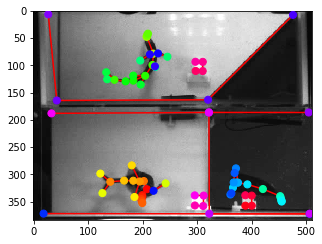

106
total frames: 114


In [6]:
frame_num = np.random.choice(len(data_generator))

image, keypoints = data_generator[frame_num]
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0) and np.all(keypoints[0, jdx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)
plt.show()
print(jdx)
print('total frames:', len(data_generator))

## set up image augmentation

In [7]:
# settings
rotation = (-20, 20)
brightness = (-50, 50)

augmenter, sometimes = [], []


sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )

sometimes.append(iaa.AdditiveGaussianNoise(loc=0,
                                           scale=(0.0, 0.05*255))
                )

sometimes.append(iaa.Add(brightness))

augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=rotation,
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)



## show augmentation example

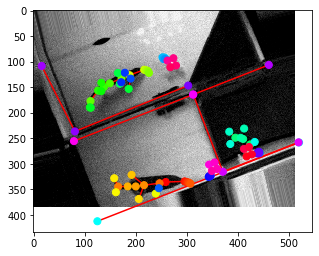

In [8]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0) and np.all(keypoints[0, jdx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# create `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [9]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=.1, 
                                    use_graph=use_skeleton,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 103,
 'n_validation': 11,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (96, 128),
 'n_output_channels': 108,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': False,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\tank_dataset_7.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 114,
 'image_shape': (384, 512, 1),
 'keypoints_shape': (108, 2)}

# check `TrainingGenerator` output

D:\anaconda3\envs\dpk\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Method `Sequential.reseed()` is deprecated. Use `imgaug.augmenters.meta.Augmenter.seed_` instead.
  warn_deprecated(msg, stacklevel=3)


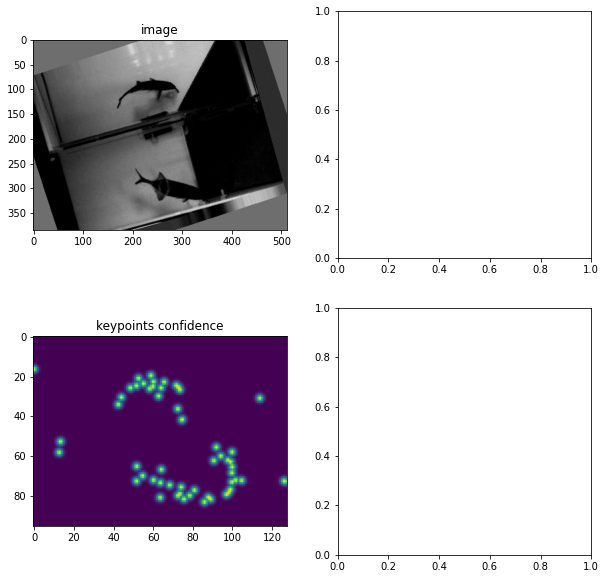

In [10]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

if use_skeleton:
    ax2.set_title('posture graph')
    ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

if use_skeleton:
    ax4.set_title('posture graph and keypoints confidence')
    ax4.imshow(outputs[0,...,-1], vmin=0)

plt.show()
train_generator.on_epoch_end()

# define a model

In [11]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)
model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 7,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 103,
 'n_validation': 11,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (96, 128),
 'n_output_channels': 108,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': False,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\tank_dataset_7.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 114,
 'image_shape': (384, 512, 1),
 'keypoints_shape': (108, 2)}

# test prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [12]:
# batch_size = 32
# data_size = (10000,) + data_generator.image_shape
# x = np.random.randint(0, 255, data_size, dtype="uint8")
# y = model.predict(x[:256], batch_size=batch_size)  # make sure the model is in GPU memory
# t0 = time.time()
# y = model.predict(x, batch_size=32, verbose=1)
# t1 = time.time()
# print(x.shape[0] / (t1 - t0))

# define training callbacks

In [13]:
logger = Logger(validation_batch_size=2,  # make sure this isn't too big!
                filepath=model_name[:-3]+'_log.h5'
)

reduce_lr = ReduceLROnPlateau(monitor="loss" if validation_split==0 else 'val_loss',
                              factor=0.2, verbose=1, patience=20)

model_checkpoint = ModelCheckpoint(
    model_name,
    monitor="loss" if validation_split==0 else 'val_loss',
    verbose=1,
    save_best_only=True,
)

early_stop = EarlyStopping(
    monitor="loss" if validation_split==0 else 'val_loss',
    min_delta=0.001,
    patience=100,
    verbose=1
)

callbacks = [logger, early_stop, reduce_lr, model_checkpoint]
# if validation_split>0:
#     callbacks.append(logger)  # todo: figure out why logger only works with validation_split>0
# callbacks = [early_stop, reduce_lr, model_checkpoint, logger]


# train

D:\github\DeepPoseKit\deepposekit\models\engine.py:145: UserWarning: 
Automatically compiling with default settings: model.compile('adam', 'mse')
Call model.compile() manually to use non-default settings.

  """\nAutomatically compiling with default settings: model.compile('adam', 'mse')\n"""


Epoch 1/800
11/12 [==========================>...] - ETA: 1s - loss: 42.3650 - output_0_loss: 14.0299 - output_1_loss: 14.1752 - output_2_loss: 14.1599evaluation_metrics: 
euclidean - mean: 58140.05 (0%:  0.37, 5%: 17.92, 25%: 179.11, 50%: 328.75, 75%: 141752.94, 95%: 141929.90, 100%: 142026.68) 
confidence - mean:  0.00 (0%:  0.00, 5%:  0.00, 25%:  0.00, 50%:  0.00, 75%:  0.00, 95%:  0.01, 100%:  0.01) 


Epoch 00001: val_loss improved from inf to 44.88767, saving model to D:\github\fish-tracking\train\models\tank_model.h5
12/12 [==============================] - 18s 1s/step - loss: 41.9568 - output_0_loss: 13.9071 - output_1_loss: 14.0330 - output_2_loss: 14.0167 - val_loss: 44.8877 - val_output_0_loss: 14.9509 - val_output_1_loss: 14.9567 - val_output_2_loss: 14.9801
Epoch 2/800
11/12 [==========================>...] - ETA: 0s - loss: 41.4125 - output_0_loss: 13.9283 - output_1_loss: 13.7742 - output_2_loss: 13.7099evaluation_metrics: 
euclidean - mean: 54728.85 (0%:  0.56, 5%:  9.8

11/12 [==========================>...] - ETA: 0s - loss: 31.4989 - output_0_loss: 12.2742 - output_1_loss: 9.9772 - output_2_loss: 9.2475 evaluation_metrics: 
euclidean - mean: 54032.22 (0%:  0.23, 5%:  1.78, 25%: 24.32, 50%: 234.08, 75%: 141764.36, 95%: 141908.09, 100%: 141950.53) 
confidence - mean:  0.03 (0%:  0.00, 5%:  0.00, 25%:  0.01, 50%:  0.01, 75%:  0.03, 95%:  0.14, 100%:  0.38) 


Epoch 00012: val_loss did not improve from 43.56356
12/12 [==============================] - 10s 857ms/step - loss: 31.5937 - output_0_loss: 12.3225 - output_1_loss: 10.0041 - output_2_loss: 9.2670 - val_loss: 43.6232 - val_output_0_loss: 14.9490 - val_output_1_loss: 14.4213 - val_output_2_loss: 14.2529
Epoch 13/800
11/12 [==========================>...] - ETA: 0s - loss: 30.6069 - output_0_loss: 11.9864 - output_1_loss: 9.6674 - output_2_loss: 8.9530evaluation_metrics: 
euclidean - mean: 54700.10 (0%:  0.28, 5%:  1.65, 25%: 33.90, 50%: 245.65, 75%: 141773.39, 95%: 141933.25, 100%: 141996.87) 
con

11/12 [==========================>...] - ETA: 0s - loss: 25.4938 - output_0_loss: 10.7448 - output_1_loss: 7.7850 - output_2_loss: 6.9640evaluation_metrics: 
euclidean - mean: 49815.24 (0%:  0.09, 5%:  0.72, 25%:  3.54, 50%: 72.05, 75%: 141777.92, 95%: 141948.69, 100%: 142014.74) 
confidence - mean:  0.14 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.04, 75%:  0.21, 95%:  0.56, 100%:  0.69) 


Epoch 00023: val_loss did not improve from 37.15591
12/12 [==============================] - 10s 856ms/step - loss: 25.5160 - output_0_loss: 10.7345 - output_1_loss: 7.7990 - output_2_loss: 6.9826 - val_loss: 39.6789 - val_output_0_loss: 14.9028 - val_output_1_loss: 12.7406 - val_output_2_loss: 12.0355
Epoch 24/800
11/12 [==========================>...] - ETA: 0s - loss: 25.6954 - output_0_loss: 10.8010 - output_1_loss: 7.8295 - output_2_loss: 7.0649evaluation_metrics: 
euclidean - mean: 57264.96 (0%:  0.04, 5%:  0.78, 25%:  2.83, 50%: 90.97, 75%: 141715.09, 95%: 141947.34, 100%: 142001.34) 
confide

Epoch 34/800
11/12 [==========================>...] - ETA: 0s - loss: 22.4818 - output_0_loss: 10.1038 - output_1_loss: 6.6073 - output_2_loss: 5.7706evaluation_metrics: 
euclidean - mean: 49789.25 (0%:  0.08, 5%:  0.67, 25%:  2.05, 50%: 12.34, 75%: 141726.00, 95%: 141949.94, 100%: 142011.68) 
confidence - mean:  0.28 (0%:  0.01, 5%:  0.01, 25%:  0.03, 50%:  0.12, 75%:  0.56, 95%:  0.83, 100%:  1.00) 


Epoch 00034: val_loss did not improve from 27.77667
12/12 [==============================] - 10s 858ms/step - loss: 22.7078 - output_0_loss: 10.2026 - output_1_loss: 6.6743 - output_2_loss: 5.8310 - val_loss: 30.1849 - val_output_0_loss: 12.5200 - val_output_1_loss: 9.2332 - val_output_2_loss: 8.4317
Epoch 35/800
11/12 [==========================>...] - ETA: 0s - loss: 22.6198 - output_0_loss: 10.1213 - output_1_loss: 6.6710 - output_2_loss: 5.8274evaluation_metrics: 
euclidean - mean: 59365.55 (0%:  0.06, 5%:  0.66, 25%:  2.27, 50%: 44.69, 75%: 141757.36, 95%: 141948.90, 100%: 142013.8

Epoch 46/800
11/12 [==========================>...] - ETA: 0s - loss: 20.3892 - output_0_loss: 9.4035 - output_1_loss: 5.8863 - output_2_loss: 5.0994evaluation_metrics: 
euclidean - mean: 53992.65 (0%:  0.06, 5%:  0.68, 25%:  1.99, 50%: 14.67, 75%: 141795.88, 95%: 141950.45, 100%: 142014.28) 
confidence - mean:  0.33 (0%:  0.00, 5%:  0.01, 25%:  0.04, 50%:  0.18, 75%:  0.63, 95%:  0.88, 100%:  1.09) 


Epoch 00046: val_loss did not improve from 26.09019
12/12 [==============================] - 10s 859ms/step - loss: 20.5371 - output_0_loss: 9.4801 - output_1_loss: 5.9270 - output_2_loss: 5.1299 - val_loss: 26.7502 - val_output_0_loss: 11.3621 - val_output_1_loss: 7.9997 - val_output_2_loss: 7.3884
Epoch 47/800
11/12 [==========================>...] - ETA: 0s - loss: 21.4383 - output_0_loss: 9.8916 - output_1_loss: 6.1758 - output_2_loss: 5.3708evaluation_metrics: 
euclidean - mean: 59510.39 (0%:  0.09, 5%:  0.79, 25%:  2.30, 50%: 44.50, 75%: 141823.33, 95%: 141953.31, 100%: 142015.87) 

Epoch 58/800
11/12 [==========================>...] - ETA: 0s - loss: 19.5968 - output_0_loss: 9.4472 - output_1_loss: 5.4721 - output_2_loss: 4.6775evaluation_metrics: 
euclidean - mean: 57139.17 (0%:  0.04, 5%:  0.59, 25%:  2.02, 50%: 22.76, 75%: 141781.30, 95%: 141949.72, 100%: 142013.15) 
confidence - mean:  0.34 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.17, 75%:  0.72, 95%:  0.95, 100%:  1.12) 


Epoch 00058: val_loss did not improve from 24.55758
12/12 [==============================] - 10s 857ms/step - loss: 19.4977 - output_0_loss: 9.4141 - output_1_loss: 5.4277 - output_2_loss: 4.6558 - val_loss: 25.9905 - val_output_0_loss: 10.9480 - val_output_1_loss: 7.7913 - val_output_2_loss: 7.2511
Epoch 59/800
11/12 [==========================>...] - ETA: 0s - loss: 18.7765 - output_0_loss: 9.0866 - output_1_loss: 5.2171 - output_2_loss: 4.4728evaluation_metrics: 
euclidean - mean: 58061.29 (0%:  0.03, 5%:  0.67, 25%:  2.21, 50%: 39.55, 75%: 141786.63, 95%: 141953.31, 100%: 142011.29) 

11/12 [==========================>...] - ETA: 0s - loss: 18.3336 - output_0_loss: 8.9860 - output_1_loss: 5.0458 - output_2_loss: 4.3017evaluation_metrics: 
euclidean - mean: 59365.03 (0%:  0.09, 5%:  0.51, 25%:  1.83, 50%: 16.10, 75%: 141773.89, 95%: 141948.16, 100%: 142013.77) 
confidence - mean:  0.35 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.19, 75%:  0.73, 95%:  0.94, 100%:  1.17) 


Epoch 00069: val_loss did not improve from 22.82672
12/12 [==============================] - 10s 856ms/step - loss: 18.3534 - output_0_loss: 8.9811 - output_1_loss: 5.0513 - output_2_loss: 4.3210 - val_loss: 25.4937 - val_output_0_loss: 11.3539 - val_output_1_loss: 7.4444 - val_output_2_loss: 6.6954
Epoch 70/800
11/12 [==========================>...] - ETA: 0s - loss: 18.2150 - output_0_loss: 8.9992 - output_1_loss: 4.9827 - output_2_loss: 4.2331evaluation_metrics: 
euclidean - mean: 58581.19 (0%:  0.06, 5%:  0.56, 25%:  1.81, 50%: 12.87, 75%: 141776.01, 95%: 141948.35, 100%: 142015.16) 
confidence -

12/12 [==============================] - 11s 889ms/step - loss: 17.3033 - output_0_loss: 8.7527 - output_1_loss: 4.6676 - output_2_loss: 3.8829 - val_loss: 22.0214 - val_output_0_loss: 9.8340 - val_output_1_loss: 6.3641 - val_output_2_loss: 5.8232
Epoch 81/800
11/12 [==========================>...] - ETA: 0s - loss: 17.6153 - output_0_loss: 8.8972 - output_1_loss: 4.7471 - output_2_loss: 3.9709evaluation_metrics: 
euclidean - mean: 59501.73 (0%:  0.08, 5%:  0.53, 25%:  1.76, 50%: 10.73, 75%: 141813.49, 95%: 141953.44, 100%: 142016.69) 
confidence - mean:  0.38 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.24, 75%:  0.76, 95%:  0.93, 100%:  1.21) 


Epoch 00081: val_loss did not improve from 22.02139
12/12 [==============================] - 10s 857ms/step - loss: 17.7301 - output_0_loss: 8.9694 - output_1_loss: 4.7740 - output_2_loss: 3.9867 - val_loss: 22.8739 - val_output_0_loss: 10.2189 - val_output_1_loss: 6.6791 - val_output_2_loss: 5.9760
Epoch 82/800
11/12 [=========================

Epoch 92/800
11/12 [==========================>...] - ETA: 0s - loss: 16.9243 - output_0_loss: 8.6782 - output_1_loss: 4.5356 - output_2_loss: 3.7105evaluation_metrics: 
euclidean - mean: 53984.17 (0%:  0.02, 5%:  0.49, 25%:  1.65, 50%:  7.92, 75%: 141758.56, 95%: 141949.60, 100%: 142015.02) 
confidence - mean:  0.39 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.27, 75%:  0.78, 95%:  0.93, 100%:  1.04) 


Epoch 00092: val_loss did not improve from 20.86232
12/12 [==============================] - 10s 855ms/step - loss: 16.7460 - output_0_loss: 8.6378 - output_1_loss: 4.4544 - output_2_loss: 3.6537 - val_loss: 21.5369 - val_output_0_loss: 9.6376 - val_output_1_loss: 6.2182 - val_output_2_loss: 5.6811
Epoch 93/800
11/12 [==========================>...] - ETA: 0s - loss: 16.3483 - output_0_loss: 8.4868 - output_1_loss: 4.3279 - output_2_loss: 3.5336evaluation_metrics: 
euclidean - mean: 49790.67 (0%:  0.10, 5%:  0.51, 25%:  1.52, 50%:  5.76, 75%: 141796.76, 95%: 141952.12, 100%: 142016.40) 


Epoch 104/800
11/12 [==========================>...] - ETA: 0s - loss: 16.1558 - output_0_loss: 8.2185 - output_1_loss: 4.3684 - output_2_loss: 3.5689evaluation_metrics: 
euclidean - mean: 57132.10 (0%:  0.06, 5%:  0.45, 25%:  1.57, 50%:  9.74, 75%: 141757.92, 95%: 141949.56, 100%: 142016.04) 
confidence - mean:  0.39 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.22, 75%:  0.80, 95%:  0.95, 100%:  1.27) 


Epoch 00104: val_loss did not improve from 20.53871
12/12 [==============================] - 10s 853ms/step - loss: 16.0083 - output_0_loss: 8.1541 - output_1_loss: 4.3183 - output_2_loss: 3.5360 - val_loss: 20.5604 - val_output_0_loss: 9.2408 - val_output_1_loss: 5.9051 - val_output_2_loss: 5.4145
Epoch 105/800
11/12 [==========================>...] - ETA: 0s - loss: 15.3024 - output_0_loss: 7.9833 - output_1_loss: 4.0481 - output_2_loss: 3.2709evaluation_metrics: 
euclidean - mean: 49786.95 (0%:  0.06, 5%:  0.41, 25%:  1.51, 50%:  5.24, 75%: 141754.34, 95%: 141957.09, 100%: 142014.82)

Epoch 116/800
11/12 [==========================>...] - ETA: 0s - loss: 15.0352 - output_0_loss: 7.7908 - output_1_loss: 4.0113 - output_2_loss: 3.2331evaluation_metrics: 
euclidean - mean: 58052.18 (0%:  0.02, 5%:  0.55, 25%:  1.70, 50%:  9.23, 75%: 141761.53, 95%: 141949.26, 100%: 142015.27) 
confidence - mean:  0.42 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.26, 75%:  0.82, 95%:  0.99, 100%:  1.18) 


Epoch 00116: val_loss did not improve from 19.99384
12/12 [==============================] - 10s 856ms/step - loss: 15.1099 - output_0_loss: 7.8228 - output_1_loss: 4.0340 - output_2_loss: 3.2531 - val_loss: 21.2697 - val_output_0_loss: 9.3107 - val_output_1_loss: 6.1730 - val_output_2_loss: 5.7860
Epoch 117/800
11/12 [==========================>...] - ETA: 0s - loss: 14.8958 - output_0_loss: 7.7919 - output_1_loss: 3.9402 - output_2_loss: 3.1637evaluation_metrics: 
euclidean - mean: 49787.80 (0%:  0.11, 5%:  0.47, 25%:  1.51, 50%:  5.24, 75%: 141797.21, 95%: 141951.64, 100%: 142018.36)

Epoch 128/800
11/12 [==========================>...] - ETA: 0s - loss: 14.5978 - output_0_loss: 7.7015 - output_1_loss: 3.8678 - output_2_loss: 3.0285evaluation_metrics: 
euclidean - mean: 57268.16 (0%:  0.04, 5%:  0.51, 25%:  1.69, 50%: 11.26, 75%: 141770.47, 95%: 141947.68, 100%: 142013.24) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.35, 75%:  0.84, 95%:  1.00, 100%:  1.15) 


Epoch 00128: val_loss did not improve from 19.75789
12/12 [==============================] - 10s 852ms/step - loss: 14.6401 - output_0_loss: 7.7178 - output_1_loss: 3.8838 - output_2_loss: 3.0384 - val_loss: 20.5006 - val_output_0_loss: 8.9570 - val_output_1_loss: 5.9196 - val_output_2_loss: 5.6240
Epoch 129/800
11/12 [==========================>...] - ETA: 0s - loss: 14.1431 - output_0_loss: 7.5152 - output_1_loss: 3.6964 - output_2_loss: 2.9315evaluation_metrics: 
euclidean - mean: 59497.85 (0%:  0.03, 5%:  0.46, 25%:  1.70, 50%:  9.32, 75%: 141767.37, 95%: 141952.29, 100%: 142018.13)

Epoch 140/800
11/12 [==========================>...] - ETA: 0s - loss: 14.1453 - output_0_loss: 7.4274 - output_1_loss: 3.7446 - output_2_loss: 2.9733evaluation_metrics: 
euclidean - mean: 53974.89 (0%:  0.05, 5%:  0.49, 25%:  1.56, 50%:  6.26, 75%: 141758.49, 95%: 141952.61, 100%: 142014.34) 
confidence - mean:  0.45 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.48, 75%:  0.85, 95%:  0.97, 100%:  1.14) 


Epoch 00140: val_loss did not improve from 19.06800
12/12 [==============================] - 10s 857ms/step - loss: 14.5200 - output_0_loss: 7.6306 - output_1_loss: 3.8455 - output_2_loss: 3.0438 - val_loss: 19.9448 - val_output_0_loss: 8.6444 - val_output_1_loss: 5.7570 - val_output_2_loss: 5.5435
Epoch 141/800
11/12 [==========================>...] - ETA: 0s - loss: 14.0828 - output_0_loss: 7.4399 - output_1_loss: 3.7031 - output_2_loss: 2.9397evaluation_metrics: 
euclidean - mean: 59356.82 (0%:  0.08, 5%:  0.52, 25%:  1.63, 50%: 10.92, 75%: 141758.14, 95%: 141948.48, 100%: 142017.05)

Epoch 152/800
11/12 [==========================>...] - ETA: 0s - loss: 13.1823 - output_0_loss: 7.1260 - output_1_loss: 3.4086 - output_2_loss: 2.6476evaluation_metrics: 
euclidean - mean: 49789.75 (0%:  0.12, 5%:  0.52, 25%:  1.44, 50%:  5.00, 75%: 141778.57, 95%: 141951.10, 100%: 142016.21) 
confidence - mean:  0.45 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.49, 75%:  0.84, 95%:  0.96, 100%:  1.18) 


Epoch 00152: val_loss did not improve from 19.06800
12/12 [==============================] - 10s 853ms/step - loss: 13.1636 - output_0_loss: 7.1457 - output_1_loss: 3.3971 - output_2_loss: 2.6207 - val_loss: 19.1236 - val_output_0_loss: 8.5560 - val_output_1_loss: 5.5039 - val_output_2_loss: 5.0638
Epoch 153/800
11/12 [==========================>...] - ETA: 0s - loss: 13.8009 - output_0_loss: 7.2844 - output_1_loss: 3.6436 - output_2_loss: 2.8728evaluation_metrics: 
euclidean - mean: 57266.20 (0%:  0.04, 5%:  0.49, 25%:  1.59, 50%:  7.79, 75%: 141764.65, 95%: 141948.30, 100%: 142016.38)

Epoch 164/800
11/12 [==========================>...] - ETA: 0s - loss: 13.2778 - output_0_loss: 7.2454 - output_1_loss: 3.4262 - output_2_loss: 2.6063evaluation_metrics: 
euclidean - mean: 49788.78 (0%:  0.04, 5%:  0.51, 25%:  1.53, 50%:  5.57, 75%: 141755.18, 95%: 141950.52, 100%: 142013.57) 
confidence - mean:  0.48 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.57, 75%:  0.86, 95%:  0.99, 100%:  1.31) 


Epoch 00164: val_loss did not improve from 18.92049
12/12 [==============================] - 10s 855ms/step - loss: 13.2763 - output_0_loss: 7.2123 - output_1_loss: 3.4335 - output_2_loss: 2.6305 - val_loss: 19.3038 - val_output_0_loss: 8.4423 - val_output_1_loss: 5.5499 - val_output_2_loss: 5.3117
Epoch 165/800
11/12 [==========================>...] - ETA: 0s - loss: 13.6767 - output_0_loss: 7.3789 - output_1_loss: 3.5655 - output_2_loss: 2.7322evaluation_metrics: 
euclidean - mean: 57266.85 (0%:  0.00, 5%:  0.51, 25%:  1.64, 50%:  8.99, 75%: 141756.53, 95%: 141952.06, 100%: 142017.65)

12/12 [==============================] - 11s 885ms/step - loss: 12.1546 - output_0_loss: 6.7358 - output_1_loss: 3.0761 - output_2_loss: 2.3428 - val_loss: 18.3904 - val_output_0_loss: 7.9601 - val_output_1_loss: 5.3038 - val_output_2_loss: 5.1265
Epoch 176/800
11/12 [==========================>...] - ETA: 0s - loss: 12.8639 - output_0_loss: 6.9182 - output_1_loss: 3.3317 - output_2_loss: 2.6140evaluation_metrics: 
euclidean - mean: 57137.70 (0%:  0.06, 5%:  0.54, 25%:  1.58, 50%:  8.21, 75%: 141765.31, 95%: 141951.10, 100%: 142015.36) 
confidence - mean:  0.46 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.50, 75%:  0.87, 95%:  1.02, 100%:  1.25) 


Epoch 00176: val_loss did not improve from 18.39043
12/12 [==============================] - 10s 848ms/step - loss: 12.7749 - output_0_loss: 6.9081 - output_1_loss: 3.2943 - output_2_loss: 2.5725 - val_loss: 19.2452 - val_output_0_loss: 8.3032 - val_output_1_loss: 5.5522 - val_output_2_loss: 5.3898
Epoch 177/800
11/12 [========================

Epoch 188/800
11/12 [==========================>...] - ETA: 0s - loss: 12.4999 - output_0_loss: 6.7558 - output_1_loss: 3.2213 - output_2_loss: 2.5228evaluation_metrics: 
euclidean - mean: 49788.64 (0%:  0.09, 5%:  0.46, 25%:  1.52, 50%:  5.10, 75%: 141736.01, 95%: 141961.62, 100%: 142017.42) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.04, 50%:  0.63, 75%:  0.88, 95%:  0.97, 100%:  1.12) 


Epoch 00188: val_loss did not improve from 18.39043
12/12 [==============================] - 10s 847ms/step - loss: 12.4739 - output_0_loss: 6.7739 - output_1_loss: 3.2048 - output_2_loss: 2.4952 - val_loss: 20.5680 - val_output_0_loss: 8.9056 - val_output_1_loss: 5.9747 - val_output_2_loss: 5.6877
Epoch 189/800
11/12 [==========================>...] - ETA: 0s - loss: 12.1124 - output_0_loss: 6.6395 - output_1_loss: 3.1042 - output_2_loss: 2.3687evaluation_metrics: 
euclidean - mean: 57528.53 (0%:  0.04, 5%:  0.58, 25%:  1.73, 50%: 19.79, 75%: 141756.73, 95%: 141955.41, 100%: 142017.39)

Epoch 200/800
11/12 [==========================>...] - ETA: 0s - loss: 11.2959 - output_0_loss: 6.4793 - output_1_loss: 2.7820 - output_2_loss: 2.0347evaluation_metrics: 
euclidean - mean: 59361.73 (0%:  0.05, 5%:  0.51, 25%:  1.64, 50%:  9.80, 75%: 141761.41, 95%: 141958.59, 100%: 142016.46) 
confidence - mean:  0.44 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.36, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00200: val_loss did not improve from 17.84337
12/12 [==============================] - 10s 854ms/step - loss: 11.1263 - output_0_loss: 6.3535 - output_1_loss: 2.7487 - output_2_loss: 2.0240 - val_loss: 19.7328 - val_output_0_loss: 8.6846 - val_output_1_loss: 5.6556 - val_output_2_loss: 5.3925
Epoch 201/800
11/12 [==========================>...] - ETA: 0s - loss: 11.2834 - output_0_loss: 6.3389 - output_1_loss: 2.8387 - output_2_loss: 2.1058evaluation_metrics: 
euclidean - mean: 58569.08 (0%:  0.05, 5%:  0.48, 25%:  1.56, 50%:  8.02, 75%: 141757.50, 95%: 141960.31, 100%: 142017.40)

11/12 [==========================>...] - ETA: 0s - loss: 11.0113 - output_0_loss: 6.2910 - output_1_loss: 2.7311 - output_2_loss: 1.9892evaluation_metrics: 
euclidean - mean: 59487.51 (0%:  0.03, 5%:  0.45, 25%:  1.54, 50%:  8.10, 75%: 141760.56, 95%: 141951.87, 100%: 142017.76) 
confidence - mean:  0.46 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.48, 75%:  0.89, 95%:  0.96, 100%:  1.10) 


Epoch 00211: val_loss did not improve from 16.87312
12/12 [==============================] - 10s 853ms/step - loss: 11.2069 - output_0_loss: 6.3590 - output_1_loss: 2.7971 - output_2_loss: 2.0508 - val_loss: 17.7490 - val_output_0_loss: 7.7296 - val_output_1_loss: 5.1095 - val_output_2_loss: 4.9098
Epoch 212/800
11/12 [==========================>...] - ETA: 0s - loss: 11.3452 - output_0_loss: 6.5387 - output_1_loss: 2.7982 - output_2_loss: 2.0083evaluation_metrics: 
euclidean - mean: 58572.23 (0%:  0.05, 5%:  0.43, 25%:  1.52, 50%:  7.99, 75%: 141758.20, 95%: 141955.04, 100%: 142013.00) 
confidence -

Epoch 223/800
11/12 [==========================>...] - ETA: 0s - loss: 11.0625 - output_0_loss: 6.2964 - output_1_loss: 2.7617 - output_2_loss: 2.0043evaluation_metrics: 
euclidean - mean: 57522.50 (0%:  0.09, 5%:  0.43, 25%:  1.55, 50%:  7.05, 75%: 141758.10, 95%: 141954.89, 100%: 142018.16) 
confidence - mean:  0.46 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.49, 75%:  0.89, 95%:  0.97, 100%:  1.12) 


Epoch 00223: val_loss improved from 16.77969 to 16.29061, saving model to D:\github\fish-tracking\train\models\tank_model.h5
12/12 [==============================] - 11s 894ms/step - loss: 11.1623 - output_0_loss: 6.3510 - output_1_loss: 2.7859 - output_2_loss: 2.0255 - val_loss: 16.2906 - val_output_0_loss: 7.1876 - val_output_1_loss: 4.6834 - val_output_2_loss: 4.4196
Epoch 224/800
11/12 [==========================>...] - ETA: 0s - loss: 10.9842 - output_0_loss: 6.3404 - output_1_loss: 2.7022 - output_2_loss: 1.9415evaluation_metrics: 
euclidean - mean: 59492.05 (0%:  0.04, 5%:  0.41,

Epoch 235/800
11/12 [==========================>...] - ETA: 0s - loss: 10.6022 - output_0_loss: 6.2176 - output_1_loss: 2.5690 - output_2_loss: 1.8156evaluation_metrics: 
euclidean - mean: 49787.92 (0%:  0.04, 5%:  0.45, 25%:  1.37, 50%:  4.56, 75%: 141774.15, 95%: 141958.77, 100%: 142018.21) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.65, 75%:  0.89, 95%:  0.96, 100%:  1.22) 


Epoch 00235: val_loss did not improve from 16.21883
12/12 [==============================] - 10s 842ms/step - loss: 10.4796 - output_0_loss: 6.1059 - output_1_loss: 2.5552 - output_2_loss: 1.8185 - val_loss: 16.9526 - val_output_0_loss: 7.4501 - val_output_1_loss: 4.8755 - val_output_2_loss: 4.6270
Epoch 236/800
11/12 [==========================>...] - ETA: 0s - loss: 11.3358 - output_0_loss: 6.4331 - output_1_loss: 2.8200 - output_2_loss: 2.0826evaluation_metrics: 
euclidean - mean: 58574.98 (0%:  0.09, 5%:  0.40, 25%:  1.54, 50%:  8.02, 75%: 141764.19, 95%: 141956.90, 100%: 142017.79)

Epoch 247/800
11/12 [==========================>...] - ETA: 0s - loss: 10.7605 - output_0_loss: 6.1731 - output_1_loss: 2.6622 - output_2_loss: 1.9252evaluation_metrics: 
euclidean - mean: 58046.85 (0%:  0.04, 5%:  0.44, 25%:  1.55, 50%:  6.98, 75%: 141759.90, 95%: 141959.19, 100%: 142018.67) 
confidence - mean:  0.46 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.52, 75%:  0.88, 95%:  0.96, 100%:  1.13) 


Epoch 00247: val_loss did not improve from 16.08650
12/12 [==============================] - 10s 843ms/step - loss: 10.6951 - output_0_loss: 6.1636 - output_1_loss: 2.6330 - output_2_loss: 1.8984 - val_loss: 16.9295 - val_output_0_loss: 7.4313 - val_output_1_loss: 4.8598 - val_output_2_loss: 4.6384
Epoch 248/800
11/12 [==========================>...] - ETA: 0s - loss: 10.9153 - output_0_loss: 6.3572 - output_1_loss: 2.6573 - output_2_loss: 1.9008evaluation_metrics: 
euclidean - mean: 49787.98 (0%:  0.12, 5%:  0.43, 25%:  1.42, 50%:  4.38, 75%: 141798.17, 95%: 141959.51, 100%: 142018.84)

Epoch 259/800
11/12 [==========================>...] - ETA: 0s - loss: 10.4629 - output_0_loss: 6.2272 - output_1_loss: 2.4980 - output_2_loss: 1.7377evaluation_metrics: 
euclidean - mean: 57264.06 (0%:  0.03, 5%:  0.45, 25%:  1.55, 50%:  8.13, 75%: 141760.32, 95%: 141951.56, 100%: 142020.84) 
confidence - mean:  0.46 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.51, 75%:  0.88, 95%:  0.97, 100%:  1.24) 


Epoch 00259: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00259: val_loss did not improve from 16.08650
12/12 [==============================] - 10s 853ms/step - loss: 10.6668 - output_0_loss: 6.2877 - output_1_loss: 2.5767 - output_2_loss: 1.8024 - val_loss: 17.7914 - val_output_0_loss: 7.7773 - val_output_1_loss: 5.1025 - val_output_2_loss: 4.9115
Epoch 260/800
11/12 [==========================>...] - ETA: 0s - loss: 10.7201 - output_0_loss: 6.2235 - output_1_loss: 2.6116 - output_2_loss: 1.8850evaluation_metrics: 
euclidean - mean: 58051.11 (0%:  0.01, 5

Epoch 271/800
11/12 [==========================>...] - ETA: 0s - loss: 10.1701 - output_0_loss: 5.9831 - output_1_loss: 2.4581 - output_2_loss: 1.7288evaluation_metrics: 
euclidean - mean: 54634.14 (0%:  0.03, 5%:  0.40, 25%:  1.46, 50%:  5.86, 75%: 141756.72, 95%: 141958.93, 100%: 142020.08) 
confidence - mean:  0.48 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.59, 75%:  0.90, 95%:  0.98, 100%:  1.22) 


Epoch 00271: val_loss did not improve from 16.08650
12/12 [==============================] - 10s 870ms/step - loss: 10.1369 - output_0_loss: 5.9923 - output_1_loss: 2.4359 - output_2_loss: 1.7086 - val_loss: 18.5917 - val_output_0_loss: 8.0869 - val_output_1_loss: 5.3549 - val_output_2_loss: 5.1500
Epoch 272/800
11/12 [==========================>...] - ETA: 0s - loss: 10.4569 - output_0_loss: 6.0194 - output_1_loss: 2.5731 - output_2_loss: 1.8643evaluation_metrics: 
euclidean - mean: 59361.27 (0%:  0.05, 5%:  0.39, 25%:  1.53, 50%:  7.42, 75%: 141759.61, 95%: 141957.41, 100%: 142020.87)

Epoch 283/800
11/12 [==========================>...] - ETA: 0s - loss: 9.9983 - output_0_loss: 6.0018 - output_1_loss: 2.3554 - output_2_loss: 1.6411evaluation_metrics: 
euclidean - mean: 58572.87 (0%:  0.01, 5%:  0.41, 25%:  1.52, 50%:  7.31, 75%: 141758.22, 95%: 141955.78, 100%: 142020.34) 
confidence - mean:  0.47 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.55, 75%:  0.90, 95%:  0.97, 100%:  1.20) 


Epoch 00283: val_loss did not improve from 15.92844
12/12 [==============================] - 10s 850ms/step - loss: 10.1712 - output_0_loss: 6.0771 - output_1_loss: 2.4140 - output_2_loss: 1.6802 - val_loss: 18.0097 - val_output_0_loss: 7.7436 - val_output_1_loss: 5.2287 - val_output_2_loss: 5.0374
Epoch 284/800
11/12 [==========================>...] - ETA: 0s - loss: 10.0770 - output_0_loss: 6.0200 - output_1_loss: 2.4095 - output_2_loss: 1.6475evaluation_metrics: 
euclidean - mean: 58049.50 (0%:  0.04, 5%:  0.42, 25%:  1.47, 50%:  6.82, 75%: 141759.90, 95%: 141959.07, 100%: 142020.14) 

Epoch 295/800
11/12 [==========================>...] - ETA: 0s - loss: 10.8166 - output_0_loss: 6.2309 - output_1_loss: 2.6609 - output_2_loss: 1.9249evaluation_metrics: 
euclidean - mean: 58047.59 (0%:  0.03, 5%:  0.43, 25%:  1.52, 50%:  6.84, 75%: 141758.42, 95%: 141956.80, 100%: 142019.26) 
confidence - mean:  0.47 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.53, 75%:  0.90, 95%:  0.97, 100%:  1.09) 


Epoch 00295: val_loss did not improve from 15.84265
12/12 [==============================] - 10s 851ms/step - loss: 10.7262 - output_0_loss: 6.1819 - output_1_loss: 2.6355 - output_2_loss: 1.9089 - val_loss: 16.5645 - val_output_0_loss: 7.2482 - val_output_1_loss: 4.7723 - val_output_2_loss: 4.5440
Epoch 296/800
11/12 [==========================>...] - ETA: 0s - loss: 10.4410 - output_0_loss: 6.1185 - output_1_loss: 2.5392 - output_2_loss: 1.7834evaluation_metrics: 
euclidean - mean: 57521.92 (0%:  0.10, 5%:  0.43, 25%:  1.48, 50%:  6.41, 75%: 141758.19, 95%: 141953.48, 100%: 142020.90)

Epoch 307/800
11/12 [==========================>...] - ETA: 0s - loss: 10.5288 - output_0_loss: 6.1626 - output_1_loss: 2.5589 - output_2_loss: 1.8073evaluation_metrics: 
euclidean - mean: 49785.21 (0%:  0.04, 5%:  0.40, 25%:  1.35, 50%:  4.60, 75%: 141754.66, 95%: 141959.25, 100%: 142020.03) 
confidence - mean:  0.51 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.69, 75%:  0.90, 95%:  0.98, 100%:  1.21) 


Epoch 00307: val_loss did not improve from 15.84265
12/12 [==============================] - 10s 857ms/step - loss: 10.6515 - output_0_loss: 6.2539 - output_1_loss: 2.5846 - output_2_loss: 1.8131 - val_loss: 16.6149 - val_output_0_loss: 7.2147 - val_output_1_loss: 4.8028 - val_output_2_loss: 4.5974
Epoch 308/800
11/12 [==========================>...] - ETA: 0s - loss: 10.2618 - output_0_loss: 5.9402 - output_1_loss: 2.5247 - output_2_loss: 1.7968evaluation_metrics: 
euclidean - mean: 58572.99 (0%:  0.04, 5%:  0.42, 25%:  1.54, 50%:  7.18, 75%: 141758.34, 95%: 141950.86, 100%: 142020.08)

Epoch 319/800
11/12 [==========================>...] - ETA: 0s - loss: 9.8830 - output_0_loss: 5.8409 - output_1_loss: 2.3626 - output_2_loss: 1.6795evaluation_metrics: 
euclidean - mean: 53973.24 (0%:  0.09, 5%:  0.42, 25%:  1.40, 50%:  5.59, 75%: 141751.04, 95%: 141949.20, 100%: 142013.14) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.63, 75%:  0.89, 95%:  0.97, 100%:  1.22) 


Epoch 00319: val_loss did not improve from 15.84265
12/12 [==============================] - 10s 849ms/step - loss: 9.7885 - output_0_loss: 5.7908 - output_1_loss: 2.3395 - output_2_loss: 1.6581 - val_loss: 16.6133 - val_output_0_loss: 7.2234 - val_output_1_loss: 4.7923 - val_output_2_loss: 4.5976
Epoch 320/800
11/12 [==========================>...] - ETA: 0s - loss: 9.9510 - output_0_loss: 5.8626 - output_1_loss: 2.3891 - output_2_loss: 1.6993evaluation_metrics: 
euclidean - mean: 57522.92 (0%:  0.09, 5%:  0.42, 25%:  1.48, 50%:  6.80, 75%: 141757.34, 95%: 141958.02, 100%: 142019.86) 
c

Epoch 331/800
11/12 [==========================>...] - ETA: 0s - loss: 10.1629 - output_0_loss: 5.9745 - output_1_loss: 2.4464 - output_2_loss: 1.7420evaluation_metrics: 
euclidean - mean: 57261.44 (0%:  0.09, 5%:  0.44, 25%:  1.51, 50%:  7.14, 75%: 141758.30, 95%: 141959.57, 100%: 142019.83) 
confidence - mean:  0.47 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.54, 75%:  0.89, 95%:  0.98, 100%:  1.22) 


Epoch 00331: val_loss did not improve from 15.84265
12/12 [==============================] - 10s 848ms/step - loss: 10.1458 - output_0_loss: 5.9539 - output_1_loss: 2.4538 - output_2_loss: 1.7380 - val_loss: 16.8454 - val_output_0_loss: 7.3231 - val_output_1_loss: 4.8344 - val_output_2_loss: 4.6879
Epoch 332/800
11/12 [==========================>...] - ETA: 0s - loss: 10.5509 - output_0_loss: 6.1463 - output_1_loss: 2.5584 - output_2_loss: 1.8462evaluation_metrics: 
euclidean - mean: 53971.60 (0%:  0.09, 5%:  0.42, 25%:  1.43, 50%:  5.53, 75%: 141750.90, 95%: 141949.17, 100%: 142013.14)

Epoch 343/800
11/12 [==========================>...] - ETA: 0s - loss: 10.1261 - output_0_loss: 6.0315 - output_1_loss: 2.4185 - output_2_loss: 1.6761evaluation_metrics: 
euclidean - mean: 53972.59 (0%:  0.09, 5%:  0.42, 25%:  1.44, 50%:  5.53, 75%: 141750.91, 95%: 141949.20, 100%: 142013.14) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.63, 75%:  0.90, 95%:  0.98, 100%:  1.22) 


Epoch 00343: val_loss did not improve from 15.84265
12/12 [==============================] - 10s 853ms/step - loss: 10.1564 - output_0_loss: 6.0815 - output_1_loss: 2.4091 - output_2_loss: 1.6658 - val_loss: 18.5721 - val_output_0_loss: 8.0475 - val_output_1_loss: 5.3595 - val_output_2_loss: 5.1651
Epoch 344/800
11/12 [==========================>...] - ETA: 0s - loss: 10.1883 - output_0_loss: 6.0501 - output_1_loss: 2.4491 - output_2_loss: 1.6891evaluation_metrics: 
euclidean - mean: 59491.92 (0%:  0.09, 5%:  0.42, 25%:  1.51, 50%:  7.36, 75%: 141759.28, 95%: 141956.61, 100%: 142019.69)

Epoch 355/800
11/12 [==========================>...] - ETA: 0s - loss: 10.4136 - output_0_loss: 6.2281 - output_1_loss: 2.4715 - output_2_loss: 1.7139evaluation_metrics: 
euclidean - mean: 58572.13 (0%:  0.09, 5%:  0.42, 25%:  1.51, 50%:  7.32, 75%: 141758.46, 95%: 141956.55, 100%: 142019.86) 
confidence - mean:  0.47 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.55, 75%:  0.89, 95%:  0.97, 100%:  1.22) 


Epoch 00355: val_loss did not improve from 15.84265
12/12 [==============================] - 10s 853ms/step - loss: 10.2332 - output_0_loss: 6.0843 - output_1_loss: 2.4435 - output_2_loss: 1.7054 - val_loss: 17.6535 - val_output_0_loss: 7.6726 - val_output_1_loss: 5.0764 - val_output_2_loss: 4.9044
Epoch 356/800
11/12 [==========================>...] - ETA: 0s - loss: 9.9118 - output_0_loss: 5.9803 - output_1_loss: 2.3274 - output_2_loss: 1.6041evaluation_metrics: 
euclidean - mean: 57126.89 (0%:  0.12, 5%:  0.37, 25%:  1.48, 50%:  6.81, 75%: 141757.63, 95%: 141948.68, 100%: 142019.83) 

Epoch 367/800
11/12 [==========================>...] - ETA: 0s - loss: 10.6639 - output_0_loss: 6.1407 - output_1_loss: 2.6277 - output_2_loss: 1.8956evaluation_metrics: 
euclidean - mean: 57261.85 (0%:  0.09, 5%:  0.44, 25%:  1.51, 50%:  7.20, 75%: 141758.48, 95%: 141959.19, 100%: 142019.83) 
confidence - mean:  0.47 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.53, 75%:  0.89, 95%:  0.97, 100%:  1.22) 


Epoch 00367: val_loss did not improve from 15.84265
12/12 [==============================] - 10s 852ms/step - loss: 10.6964 - output_0_loss: 6.1900 - output_1_loss: 2.6232 - output_2_loss: 1.8832 - val_loss: 15.9269 - val_output_0_loss: 6.9601 - val_output_1_loss: 4.5834 - val_output_2_loss: 4.3835
Epoch 368/800
11/12 [==========================>...] - ETA: 0s - loss: 10.2099 - output_0_loss: 5.9952 - output_1_loss: 2.4707 - output_2_loss: 1.7440evaluation_metrics: 
euclidean - mean: 58048.91 (0%:  0.09, 5%:  0.42, 25%:  1.51, 50%:  7.31, 75%: 141759.15, 95%: 141959.24, 100%: 142019.83)

Epoch 379/800
11/12 [==========================>...] - ETA: 0s - loss: 10.5984 - output_0_loss: 6.2140 - output_1_loss: 2.5871 - output_2_loss: 1.7973evaluation_metrics: 
euclidean - mean: 59492.06 (0%:  0.09, 5%:  0.44, 25%:  1.50, 50%:  7.41, 75%: 141759.15, 95%: 141955.51, 100%: 142019.83) 
confidence - mean:  0.47 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.53, 75%:  0.89, 95%:  0.97, 100%:  1.22) 


Epoch 00379: val_loss did not improve from 15.84265
12/12 [==============================] - 10s 850ms/step - loss: 10.5116 - output_0_loss: 6.1683 - output_1_loss: 2.5630 - output_2_loss: 1.7803 - val_loss: 17.2662 - val_output_0_loss: 7.4183 - val_output_1_loss: 5.0104 - val_output_2_loss: 4.8375
Epoch 380/800
11/12 [==========================>...] - ETA: 0s - loss: 10.2204 - output_0_loss: 5.9901 - output_1_loss: 2.4724 - output_2_loss: 1.7579evaluation_metrics: 
euclidean - mean: 53972.09 (0%:  0.09, 5%:  0.43, 25%:  1.45, 50%:  5.56, 75%: 141750.80, 95%: 141949.20, 100%: 142013.17)

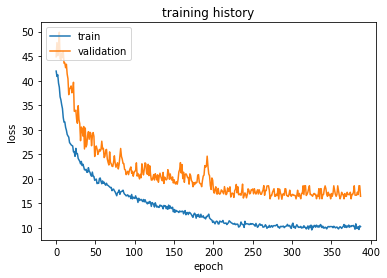

In [14]:
# train
history = model.fit(
    batch_size=8,             # adjust as training set expands
    validation_batch_size=2,  # adjust as training set expands
    callbacks=callbacks,
    epochs=800,
    n_workers=8,
    steps_per_epoch=None,     # set to None for automatic determination
)

# plot training
ax = plt.axes(title='training history', xlabel='epoch', ylabel='loss')
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left');